# Imports and Dependencies

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import standard_normal, seed
import scipy.stats as stats
from scipy.stats import norm
import sys
import datetime 
import time
import bspline
import bspline.splinelab as splinelab
import matplotlib.pyplot as plt

# Defining Black-Scholes Formulas for European Options

In [7]:
# Black-Scholes formula (for comparison)
def bs_put(t, S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price

# Defining the DiscreteBlackScholes Class
This cell defines a class DiscreteBlackScholes that encapsulates the simulation of stock price paths and the pricing of American options using a replicating portfolio approach with LSM for early exercise. The class handles path generation, intrinsic value calculation, and backward induction for option valuation and hedging.
Key components of the class:
* __init__(self, s0, strike, vol, T, r, mu, numSteps, numPaths, option_type='P'): Initializes the object with parameters like initial stock price (s0), strike, volatility (vol), time to maturity (T), risk-free rate (r), actual drift (mu), number of time steps (numSteps), number of Monte Carlo paths (numPaths), and option type ('P' for put, 'C' for call). It sets up arrays for stock prices (sVals), option values (optionVals), intrinsic values (intrinsicVals), cash positions (bVals), and hedging deltas (opt_hedge). It also computes the time step (dt) and discount factor (gamma = exp(-r*dt)). A coefficient coef is set to 0 for pure risk-neutral hedging.
* gen_paths(self): Generates Monte Carlo paths for stock prices using geometric Brownian motion. It seeds the random number generator for reproducibility, simulates normal random variables (Z), and updates stock prices step-by-step: sVals[:, step+1] = sVals[:, step] * exp((mu - 0.5*vol^2)*dt + vol*sqrt(dt)*Z[:, step]). It also computes adjusted stock changes (delta_S_hat) for hedging, transforms state variables (X) using logs for regression, and prepares B-spline basis functions (data) for LSM regression (with 4th-order splines and 12 knots).
* seed_intrinsic(self): Initializes the intrinsic (exercise) value matrix for each path and time step. For puts: max(strike - sVals, 0); for calls: max(sVals - strike, 0). At maturity (numSteps), the option value equals the intrinsic value, and cash positions are set accordingly.
* function_A_vec(self, t, reg_param=1e-3): Computes the regression matrix A for optimal hedging at time t. It uses the B-spline basis (X_mat) weighted by squared adjusted stock changes (hat_dS2), with a small regularization term (reg_param * eye) to stabilize inversion.
* function_B_vec(self, t, Pi_hat): Computes the vector B for hedging regression, incorporating adjusted portfolio values (Pi_hat), stock changes, and a drift adjustment term (if coef != 0).
* roll_backward(self): Performs backward induction using LSM to compute American option values and optimal hedges:
  - Starts from maturity and rolls back to time 0.
  - For each time t (from numSteps-1 to 0):
    * Computes expected next portfolio values (piNext) and adjusts them (pi_hat).
    * Solves for optimal hedge (opt_hedge[:, t]) via linear regression: phi = inv(A) * B, then applies basis functions.
    * Sets default continuation value as discounted next option value.
    * For in-the-money paths (intrinsic > 0), regresses discounted next option values on B-splines to estimate continuation values.
    * Compares continuation vs. exercise: If exercise value > continuation, update option value to exercise (early exercise decision).
    * Updates cash positions (bVals) based on discounted future cash and hedge adjustments.
  - Finally, computes the initial portfolio value (mean across paths), its variance, and initial delta (mean hedge).
* The class returns the American option value, initial delta, and value variance.

In [12]:
class DiscreteBlackScholes:
    """
    The extended DiscreteBlackScholes class, used to simulate the value of a replicating portfolio for American options.
    """
    def __init__(self,
                 s0,
                 strike,
                 vol,
                 T,
                 r,
                 mu,
                 numSteps,
                 numPaths,
                 option_type='P'): 
        """
        :param s0: Initial stock price
        :param strike: option exercise price
        :param vol: volatility
        :param T: Maturity period (years)
        :param r: risk-free interest rate
        :param mu: Actual drift rate
        :param numSteps: time steps
        :param numPaths: Monte Carlo path number
        :param option_type: The types of options: 'P' stands for put, 'C' stands for call.
        """
        self.s0 = s0
        self.strike = strike
        self.vol = vol
        self.T = T
        self.r = r
        self.mu = mu
        self.numSteps = numSteps
        self.numPaths = numPaths
        self.option_type = option_type

        self.dt = self.T / self.numSteps  # time step
        self.gamma = np.exp(-r * self.dt)  # single-step discount factor

        # Initialise array
        self.sVals = np.zeros((self.numPaths, self.numSteps + 1), 'float')  # Stock price matrix
        self.sVals[:, 0] = s0 * np.ones(numPaths, 'float')
        self.optionVals = np.zeros((self.numPaths, self.numSteps + 1), 'float')  # Option Value Matrix
        self.intrinsicVals = np.zeros((self.numPaths, self.numSteps + 1), 'float')  # Intrinsic Value Matrix
        self.bVals = np.zeros((self.numPaths, self.numSteps + 1), 'float')  # Cash position matrix
        self.opt_hedge = np.zeros((self.numPaths, self.numSteps + 1), 'float')  # Optimal Hedging Matrix
        self.X = None
        self.data = None  # Feature matrix (B-spline basis function)）
        self.delta_S_hat = None

        self.coef = 0.  # Set to 0 to use pure risk hedging

    def gen_paths(self):
        """
        Generate stock price paths
        """
        np.random.seed(405)
        Z = np.random.normal(0, 1, size=(self.numPaths, self.numSteps))
        for step in range(self.numSteps):
            self.sVals[:, step+1] = self.sVals[:, step] * np.exp((self.mu - 0.5 * self.vol**2) * self.dt + self.vol * np.sqrt(self.dt) * Z[:, step])

        delta_S = self.sVals[:, 1:] - np.exp(self.r * self.dt) * self.sVals[:, :self.numSteps]
        self.delta_S_hat = delta_S - np.mean(delta_S, axis=0)

        # 状态变量（用于回归）
        self.X = - (self.mu - 0.5 * self.vol ** 2) * np.arange(self.numSteps + 1) * self.dt + np.log(self.sVals)

        X_min = np.min(np.min(self.X))
        X_max = np.max(np.max(self.X))

        p = 4  # B-spline 阶数
        ncolloc = 12
        tau = np.linspace(X_min, X_max, ncolloc)
        k = splinelab.aptknt(tau, p)
        basis = bspline.Bspline(k, p)
        num_basis = ncolloc
        self.data = np.zeros((self.numSteps + 1, self.numPaths, num_basis))

        for ix in np.arange(self.numSteps + 1):
            x = self.X[:, ix]
            self.data[ix, :, :] = np.array([basis(el) for el in x])

    def seed_intrinsic(self):
        """
        Initialise the intrinsic value of each node
        """
        if self.option_type == 'P':
            self.intrinsicVals = np.maximum(self.strike - self.sVals, 0)
        elif self.option_type == 'C':
            self.intrinsicVals = np.maximum(self.sVals - self.strike, 0)
        else:
            raise Exception('Invalid option type: %s' % self.option_type)

        # The value of an option at expiry is equal to its intrinsic value.
        self.optionVals[:, -1] = self.intrinsicVals[:, -1]
        self.bVals[:, -1] = self.intrinsicVals[:, -1]

    def function_A_vec(self, t, reg_param=1e-3):
        """
        Calculate the matrix A_{nm} for delta hedging.
        """
        X_mat = self.data[t, :, :]
        num_basis_funcs = X_mat.shape[1]
        this_dS = self.delta_S_hat[:, t]
        hat_dS2 = (this_dS ** 2).reshape(-1, 1)
        A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
        return A_mat

    def function_B_vec(self, t, Pi_hat):
        """
        Calculate vector B_{n} for delta hedging
        """
        tmp = Pi_hat * self.delta_S_hat[:, t] + self.coef * (np.exp((self.mu - self.r) * self.dt)) * self.sVals[:, t]
        X_mat = self.data[t, :, :]
        B_vec = np.dot(X_mat.T, tmp)
        return B_vec

    def roll_backward(self):
        """
        Use the Longstaff-Schwartz method for backwards induction to calculate the value of American options and hedging strategies.
        """
        for t in range(self.numSteps - 1, -1, -1):
            # Calculate the expected portfolio value at the next time point
            piNext = self.bVals[:, t+1] + self.opt_hedge[:, t+1] * self.sVals[:, t+1]
            pi_hat = piNext - np.mean(piNext)

            # Calculate the optimal hedge
            A_mat = self.function_A_vec(t)
            B_vec = self.function_B_vec(t, pi_hat)
            phi = np.dot(np.linalg.inv(A_mat), B_vec)
            self.opt_hedge[:, t] = np.dot(self.data[t, :, :], phi)

            # The default continuation value is the option value at the next time step after a discount.
            self.optionVals[:, t] = self.gamma * self.optionVals[:, t+1]

            # Find the intrinsic paths (intrinsicVals > 0)
            idx = np.where(self.intrinsicVals[:, t] > 0)[0]
            if len(idx) > 0:
                # Perform regression on the in-price path
                X_t = self.data[t, :, :]
                X_itm = X_t[idx]  # Basis function of the in-the-money path
                Y_itm = self.gamma * self.optionVals[idx, t+1]  # Discounted value of the in-price path
                reg = np.linalg.lstsq(X_itm, Y_itm, rcond=None)
                beta = reg[0]
                continuation_value = np.dot(X_itm, beta)  # The continuing value of the estimated price path
                exercise_value = self.intrinsicVals[idx, t]  # Exercise Value
                
                #If the exercise value is greater than the continuation value, then exercise the option.
                exercise_decision = exercise_value > continuation_value
                self.optionVals[idx[exercise_decision], t] = exercise_value[exercise_decision]

            # Update cash position
            self.bVals[:, t] = self.gamma * (self.bVals[:, t+1] + (self.opt_hedge[:, t+1] - self.opt_hedge[:, t]) * self.sVals[:, t+1])

        # Calculate the initial portfolio value
        initPortfolioVal = self.bVals[:, 0] + self.opt_hedge[:, 0] * self.sVals[:, 0]

        optionVal = np.mean(initPortfolioVal)
        optionValVar = np.std(initPortfolioVal)
        delta = np.mean(self.opt_hedge[:, 0])

        return optionVal, delta, optionValVar

    # Compute Portfolio Error
    def compute_portfolio_errors(self):
        "        \"\"\"\n",
        "        Compute the portfolio error at the exercise time for each path.\n",
        "        - Find the exercise time tau for each path (earliest t where optionVals == intrinsicVals).\n",
        "        - Error = portfolio value at tau - intrinsic value at tau.\n",
        "        - Return mean and std of errors.\n",
        "        \"\"\"\n",
        errors = np.zeros(self.numPaths)
        for p in range(self.numPaths):
            for t in range(self.numSteps + 1):
                if np.isclose(self.optionVals[p, t], self.intrinsicVals[p, t]):
                    tau = t
                    port_val = self.bVals[p, tau] + self.opt_hedge[p, tau] * self.sVals[p, tau]
                    errors[p] = port_val - self.intrinsicVals[p, tau]
                    break
        mean_error = np.mean(errors)
        std_error = np.std(errors)
        return mean_error, std_error

# Setting Parameters and Running the Simulation

In [13]:
s0 = 100.0
strike = 100.0
r = 0.03
mu = r
vol = 0.15
T = 1.0
numPaths = 10000
numSteps = 50
option_type = 'P'  # put option

hMC = DiscreteBlackScholes(s0, strike, vol, T, r, mu, numSteps, numPaths, option_type)

# calculation
hMC.gen_paths()
hMC.seed_intrinsic()
option_val, delta, option_val_variance = hMC.roll_backward()
bs_call_value = bs_put(0, s0, K=strike, r=r, sigma=vol, T=T)
mean_err, std_err = hMC.compute_portfolio_errors()

print('American Option value = ', option_val)
print('Option delta = ', delta)
print('Mean Portfolio Error at Exercise = ', mean_err)
print('Standard Deviation of Portfolio Error = ', std_err)
print('BS value', bs_call_value)

American Option value =  4.434225875942974
Option delta =  -0.34196418811917645
Mean Portfolio Error at Exercise =  1.8602559954651352
Standard Deviation of Portfolio Error =  3.087910640058822
BS value 4.529640948763429


# Visualization: Stock Price vs Portfolio Value

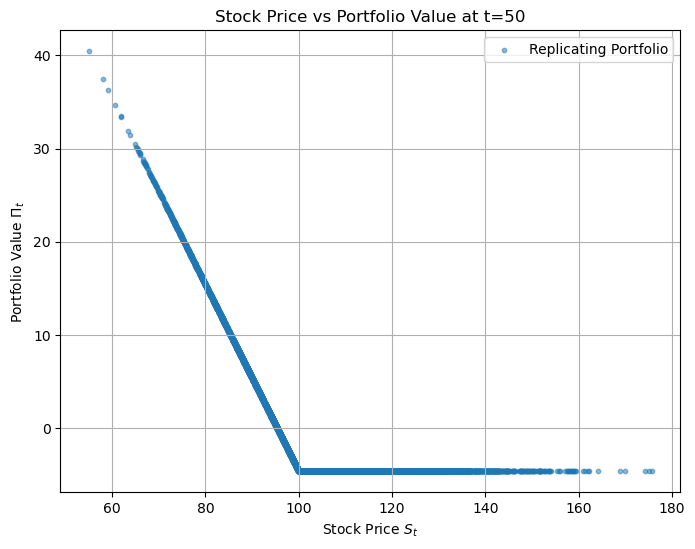

In [7]:
# Choose the last moment (or any moment, such as t = numSteps//2)
t = hMC.numSteps  # at maturity
pi = hMC.bVals[:, t] + hMC.opt_hedge[:, t] * hMC.sVals[:, t]
portfolio_vals = pi - np.mean(pi)
stock_vals = hMC.sVals[:, t]

plt.figure(figsize=(8,6))
plt.scatter(stock_vals, portfolio_vals, alpha=0.5, s=10, label="Replicating Portfolio")
plt.xlabel("Stock Price $S_t$")
plt.ylabel("Portfolio Value $\Pi_t$")
plt.title(f"Stock Price vs Portfolio Value at t={t}")
plt.legend()
plt.grid(True)
plt.savefig("Stock Price vs Portfolio Value at t=50.png")
plt.show()

# Creating and Displaying an Animation
This cell visualizes the relationship between stock prices and replicating portfolio values over time

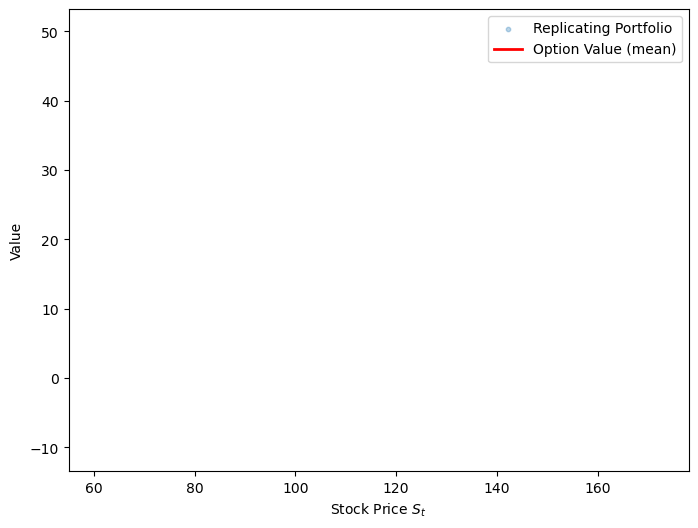

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

portfolio_vals = hMC.bVals + hMC.opt_hedge * hMC.sVals

fig, ax = plt.subplots(figsize=(8,6))
scat = ax.scatter([], [], alpha=0.3, s=10, label="Replicating Portfolio")
line, = ax.plot([], [], 'r-', lw=2, label="Option Value (mean)")
ax.set_xlim(np.min(hMC.sVals), np.max(hMC.sVals))
ax.set_ylim(np.min(portfolio_vals), np.max(portfolio_vals))
ax.set_xlabel("Stock Price $S_t$")
ax.set_ylabel("Value")
title = ax.set_title("")
ax.legend()

def init():
    scat.set_offsets(np.empty((0, 2)))   # ✅ fix 1
    line.set_data([], [])
    title.set_text("")
    return scat, line, title

def update(frame):
    x = hMC.sVals[:, frame]
    y = portfolio_vals[:, frame]
    scat.set_offsets(np.c_[x, y])   # ✅ N×2 

    bins = np.linspace(np.min(hMC.sVals), np.max(hMC.sVals), 50)
    digitized = np.digitize(x, bins)
    option_curve = [np.mean(hMC.optionVals[:, frame][digitized == i]) if np.any(digitized == i) else np.nan
                    for i in range(1, len(bins))]

    line.set_data(bins[:-1], option_curve)
    title.set_text(f"t = {frame}/{hMC.numSteps}")
    return scat, line, title

ani = animation.FuncAnimation(fig, update, frames=hMC.numSteps+1,
                              init_func=init, interval=200, blit=False, repeat=True)

# Interactive display in JupyterLab
HTML(ani.to_jshtml())